# Mock Data for Compressed Matrices



### taken from `https://github.com/bamler-lab/webgl-entropy-coding`

## File Format Specification

We store $K$ compressed matrices $W_0, \dots, W_{K-1}$, and a single uncompressed vector $v_0$.

- For $k \in \{0, \ldots, K-1\}$, the matrix $W_k$ has dimension $N_{k+1} \times N_k$.
- The vector $v_0$ has dimension $N_0$.

Thus, the statement $v_K := W_{K-1} W_{K-2} \ldots W_0 v_0$ denotes a valid sequence of matrix-vector multiplications with matching dimensions, resulting in a vector $v_K$ with dimension $N_K$.

### Overall Container Format

The overall file layout is structured as follows:

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & K   & S_\text{max} & N_0 & v_0     & \texttt{pad} & W_0              & W_1              & \cdots & W_{K-1} \\ \hline
      \text{type:} & u32 & u32          & u32 & i8[N_0] & u8[3 - ((N_0 + 3) \operatorname{mod} 4)]         & \text{see below} & \text{see below} & \cdots & \text{see below}   \\ \hline
  \end{array}
$

Here,

- `u<X>` (e.g., $u8$, $u32$) denotes an unsigned $X$-bit integer value;
- `i<X>` (e.g., $i8$) denotes a signed $X$-bit integer value;
- all numbers are stored in little endian byte order;
- `{u, i}<X>[size]`, i.e., a type followed by braces (e.g., $i8[N_0]$) denotes a densely packed array of `size` elements of the same type;
- $S_\text{max}$ is the maximum size of the compressed representation (see below) of any of the involved matrices $W_0, \ldots, W_{K-1}$, including matrix headers (as described below), measured in units of 16 bit (2 byte).
- `pad` contains either 0, 1, 2, or 3 bytes whose values will be ignored by the decoder;
  its length $l_\text{pad} \in \{0,1,2,3\}$ is determined such that $N_0 + l_\text{pad}$ is an integer multiple of $4$, so that the subsequent fields can be 32-bit aligned;
- the compressed representation of the matrices $W_0, \ldots, W_{K-1}$ is detailed below.

### Matrix Container Format

In the above overall container format, each matrix $W_k$ for $k\in \{0,\ldots,K-1\}$ is stored in the following layout:

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & N_{k+1} & N_{k} & \delta & \texttt{cursors} & \texttt{payload\_size} & \hat{w}_\text{min} & |G| & \texttt{cdf} & \texttt{pad} & \texttt{ppf}& \texttt{payload} \\ \hline
      \text{type:} & u32   & u32     & f32    & u32[N_{k+1}]     & u32                    & i8                 & u8  & u8[|G| + 1]  &  u8[(|G|+1) \operatorname{mod} 2]     & u8[256] & u16[\texttt{payload\_size}] \\ \hline
  \end{array}
$

- **TODO:** maybe we should flush the coders after each matrix. The overhead is negligible (32 bit per matrix row, i.e., same as the overhead for the `cursors`)

Here,

- $\delta$ is the distance between neighboring grid points; i.e., if $\hat{W}_k \in \mathbb{Z}^{N_{k+1}\times N_k}$ is the integer representation of the decoded quantized matrix, then the true quantized matrix is $W_k = \delta \hat{W}_k$, and thus, for a vector-matrix multiplication $v_{k+1} := W_k v_k$, we have $v_{k+1} = \delta \hat{v}_{k+1}$ where $\hat{v}_{k+1} := \hat{W}_k v_k$.
- `cursors` is an array of the size of the output dimension $N_{k+1}$ which, for each matrix row, contains an offset into `payload` where additional compressed data for this matrix row (if needed) starts; offsets are measured in units of 16 bit (2 byte), and relative to the start of the `payload` field (thus, `cursors[0]` is always `0`);
- `payload_size` is the length of the `payload` field, measured in units of 16 bit (2 byte);
  since the `payload_size` field directly follows the `cursors` field, `payload_size` can be interpreted as an $(N_{k+1}+1)$-th cursor pointing to where the compressed data for an additional matrix row would start if there was one more matrix row.
  - Due to payload padding (see below), `payload_size` is always even (so that all compressed matrix structs are 32-bit aligned).
- $\hat{w}_\text{min}$ is the smallest value present in the integer representation $\hat{W}_k$ of the quantized matrix.
- $|G|$ is the grid size; we assume a uniform grid, i.e., the integer representation $\hat{W}_k$ of the quantized matrix takes only values from the range $\{\hat{w}_\text{min}, {\hat{w}_\text{min} + 1}, \ldots, {\hat{w}_\text{min} + |G| - 1}\}$.
- `cdf` is the cumulative distribution function of the entropy model in 8-bit unsigned integer representation.
  Its interpretation is that it defines a probability mass function (PMF) via $\texttt{pmf}[r] := (\texttt{cdf}[r + 1] - \texttt{cdf}[r]) \operatorname{mod} 2^8 \;\forall r \in \{0, 1, \ldots, |G|-1\}$.
  Here, the "$\operatorname{mod} 2^8$" wraps only for the last entry, $\texttt{pmf}[|G|-1] = {(0 - \texttt{cdf}[r]) \operatorname{mod} 2^8} = 2^8 - \texttt{cdf}[|G|-1]$, which is enforced by the requirements $\texttt{cdf}[|G|] = 0$ and $\texttt{cdf}[|G|-1] > 0$, see below, and the fact that $\texttt{cdf}[|G|-1] < 2^8$ since $\texttt{cdf}[|G|-1]$ is an unsigned 8-bit integer.
  The `cdf` it satisfies the following properties:
  - The first $|G|$ entries of `cdf` make up a nonincreasing sequence: `cdf[0] <= cdf[1] <= ... <= cdf[|G| - 1]`.
  - `cdf[0] = cdf[|G|] = 0`.
  - `cdf[|G| - 1] > 0` (which implies that $|G| \geq 2$ since `cdf[0] = 0`);
    thus, the entropy model must not represent a delta distribution that puts all probability mass on a single grid point;
    this requirement enables a simplification in the implementation of the ANS algorithm while anyway only affecting the pathological edge case where all matrix elements of $\hat{W}_k$ are equal.
    This pathological edge case can still be treated efficiently, e.g., by setting $|G|=2$, setting $\hat{w}_\text{min}$ to the value taken by all matrix elements, and setting $\texttt{cdf} = [0, 255, 0]$.
    With these settings, the entropy model puts almost all probability mass on the entry taken by all matrix elements and only a tiny probability mass on an irrelevant dummy grid point, resulting in a cross entropy of $\log_2(\frac{256}{255}) \approx 0.0056$ bit per matrix element.
  - If `cdf[r] = cdf[r + 1]` for some $r \in \{0, \ldots, {|G|-2}\}$, then this means that the entropy model assigns zero probability mass to the value ${\hat{w}_\text{min} + r}$, and therefore $\hat{W}_k$ must not contain any matrix entry with value ${\hat{w}_\text{min} + r}$ because this value cannot be encoded with this entropy model.
- `pad` is either nothing or a single byte with arbitrary value that should be ignored by the decoder.
  This byte is inserted if the grid size $|G|$ is even to ensure that the `payload` can be properly 16-bit aligned.
- `payload` contains the compressed data, see below.

### Compressed Bit String Representation & Decoding

We define the format of the `payload` field in the above matrix container format by specifying the decoding process.
The encoding algorithm follows from this specification as encoding is inference over a decoder.

When decoding the $k$-th matrix with dimensions $N_{k+1}\times N_k$, the decoder operates on the $N_{k+1}$ matrices independently (and thus, possibly in parallel).
All decoders need read access to the shared `cdf` of the entropy model, the shared `payload` of the compressed matrix, and a coder-specific cursor $C_i$ that gets initialized at the beginning of each matrix-decoding process from `cursor[i]` declared in the matrix container format.
A practical implementation will likely also want to create a shared `ppf` lookup table that stores the inverse of `cdf` to speed up steps 2 and 3 below.

Decoding the $i$-th row of matrix $W_k$ works as follows:

- Initialize the row's cursor $C_i \gets \texttt{cursors}[i]$, where `cursors` is a field of the matrix container format specified above.
- Initialize an unsigned 32-bit coder state $S_i \gets (\texttt{payload}[C_i] \ll 16) \;|\; \texttt{payload}[C_i+1]$, where "$\ll$" denotes left bit-shift and "$|$" denotes bitwise or.
  Thus, the 32-bit coder state $S_i$ is initialized to the concatenation of the first two 16-bit words read off the `payload` starting from the row's initial cursor.
- Increment the curser accordingly: $C_i \gets C_i + 2$.
- For each column $j \in \{0,\ldots,N_k-1\}$ (in ascending order) do:
  1. Set `quantile` ← least significant 8 bits of the coder state $S_i$
  2. Set `r` to the uniquely defined number in $\{0,\ldots,|G|-1\}$ such that `cdf[r] <= quantile < cdf[r+1]`.
  3. Set the (integer representation of the) decoded matrix element to $(\hat{W}_k)_{ij} \gets r + \hat{w}_\text{min}$.
  4. Update the coder state $S_i \gets (S_i \gg 8) \times$ `((cdf[r+1] - cdf[r]) mod 256)` + `(quantile - cdf[r])`,
     where "$\gg$" denotes left bit shift (that is _unsigned_, i.e., it fills from the right with zero bits).
  5. If $S_i < 2^{16}$ (i.e., if the 16 most significant bits of the 32-bit number $S_i$ are all zero, or, equivalently, if $(S_i \gg 16) = 0$), then:
     - Update $S_i \gets (S_i \ll 16) \;|\; \texttt{payload}[C_i]$,
       where "$\ll$" denotes left bit shift, and "$|$" denotes bitwise `or` (this update can be understood as concatenating $\texttt{payload}[C_i]$ to $S_i$ since $\texttt{payload}[C_i]$ is a 16-bit unsigned integer).
     - Increment $C_i \gets C_i + 1$.

### Encoding

A valid encoder is any program that generates a file in the format specified above such that decoding the file with the decoding algorithm specified above generates the desired (quantized) matrices $\hat{W}_0, \ldots, \hat{W}_{K-1}$.

In practice, encoding a quantized matrix $W_k$ of shape $N_{k+1} \times N_k$ can be performed as follows:

- Prepare an integer representation $\hat{W}_k \in \mathbb{Z}^{N_k \times N_{k+1}}$ of the quantized matrix and determine its minimum $\hat{w}_\text{min} := \min_{i,j} (\hat{W}_k)_{ij}$ and grid size $|G| := \max_{i,j} (\hat{W}_k)_{ij} - \hat{w}_\text{min} + 1 \ge 2$.
- Prepare a suitable `cdf` for $\hat{W}_k$.
- Initialize `reverse_payload` ← empty growable array of `u16`.
- For each row $i \in \{0,\ldots,N_{k+1}-1\}$ in _descending_ order, do (note: this could be parallelized without changing the result):
  - Initialize an unsigned 32-bit coder state $S \gets 2^{16}$.
  - For each column $j \in \{0,\ldots,N_k-1\}$ in _descending_ order, do:
    1. Set $r \gets (\hat{W}_k)_{ij} - \hat{w}_\text{min}$; (thus, $r \in \{0,\ldots, |G|-1\}$).
    2. Set `probability ← (cdf[r+1] - cdf[r]) mod 256`.
    3. If $(S \gg 24) \geq \texttt{probability}$ (i.e., if dividing $S$ by `probability` and then shifting it by 8 bit to the left would overflow its 32-bit size):
       - Push the 16 least significant bits of $S$ to the end of `reverse_payload`.
       - Update $S \gets (S \gg 16)$.
    4. Set $\texttt{quantile} \gets \texttt{cdf}[r] + (S \,\operatorname{mod}\, \texttt{probability})$;
       thus, $\texttt{quantile} \in \{0, \ldots, 255\}$.
    5. Update $S \gets (\lfloor S / \texttt{probability} \rfloor \ll 8) \;|\; \texttt{quantile}$,
       where "$\lfloor \,\cdot\,\rfloor$" denotes rounding down to an integer.
  - Push first the least significant 16 bit and then the most significant 16 bit of $S$ to the end of `reverse_payload`.
  - Set `back_cursor[i] ← length(reverse_payload)`, where length is measured in units of 16 bit.
- Obtain `payload` by reversing the order of elements in the array `reverse_payload`.
- For each $i \in \{0,\ldots,N_{k+1}-1\}$, set `cursor[i] ← length(payload) - back_cursor[i]`.
  Thus, we should have `cursor[0] = 0`.
- if `payload` has an odd length (i.e., contains an odd number of `u16`s), then append a single additional `u16` with arbitrary value (e.g., zero) to it to make it an even length.

In [55]:
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import struct
import sys

## Create Random Quantized Matrices

100%|██████████| 20/20 [00:00<00:00, 75.99it/s]


mins: [-127 -127 -127 -127 -127 -113 -127 -127 -107 -121 -119 -127 -127 -127
 -109 -127 -127 -119 -127 -123]
maxs: [123 123 123 127 125 127 127 113 127 127 127 121 119 107 127 117 125 127
 115 127]
Entropy in bits: 5.857737402753593


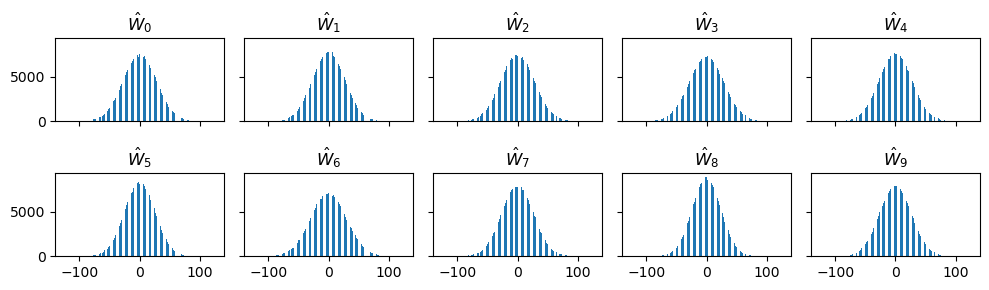

In [56]:
np.random.seed(20250310)

w = 512
sigma = 1/np.sqrt(w)
n = 20
precision = 8

entropy = 7 # upper bound

quantized_matrices = np.empty((n,w,w), dtype=np.int8)
w_deltas = np.zeros(n)
for i in tqdm(range(n)):
    matrix = np.random.randn(w, w)* sigma
    max_value = (2**(entropy-1))-1 # for signed integer maximum value is (2**(entropy-1))-1, neglecting -2**(entropy-1)
    w_delta =  np.abs(matrix).max()/max_value  # quantize matrices to int8 grid
    w_deltas[i] = w_delta # store as weight delta
    quantized_matrices[i,...] = np.round(np.round( matrix/ w_delta ) * 127 / max_value).astype(np.int8)

print(f'mins: {quantized_matrices.min(axis=(1, 2))}')
print(f'maxs: {quantized_matrices.max(axis=(1, 2))}')

fig, axs = plt.subplots(2, 5, figsize=(10, 3), sharex=True, sharey=True, tight_layout=True)
bins = np.arange(-np.abs(quantized_matrices).max() - 0.5, np.abs(quantized_matrices).max() + 1.5)
for i, ax in enumerate(axs.flat):
    ax.hist(quantized_matrices[i ].ravel(), bins=bins)
    ax.set_title(r'$\hat{W}_{' + str(i) + r'}$')

vector = np.round(np.random.randn(w) * 4).astype(np.int8)


values, counts = np.unique(quantized_matrices[0], return_counts=True)
probs = counts/ counts.sum()
print(f"Entropy in bits: {probs @ -np.log2(probs)}")

## Calculate Result in python

In [57]:
deltas_a = np.zeros(n)
v_delta = 1
v_int8 = vector.copy()
for i,mat in enumerate(quantized_matrices):
    # .astype(np.int32) to not overflow while accumulating
    if i==0:
        print(mat.astype(float)[:4,0])
    v_int32 = (mat.astype(float) @ v_int8.astype(float))
    
    # multiply w_deltas and v_delta to scale back to original values
    v_f32 = v_int32 * w_deltas[i] * v_delta

    # requantization to align again to  int8 
    v_delta = np.abs(v_f32).max() / 127 

    v_int8 = (v_f32 / v_delta)
    v_int8 = np.round(v_int8) # rounding for quantization

print(list(v_int8))

[ 40.  12. -38.  10.]
[-70.0, -12.0, -42.0, -126.0, 50.0, 39.0, -32.0, -35.0, -1.0, -79.0, -30.0, -18.0, -28.0, 10.0, -62.0, -39.0, -36.0, 104.0, -80.0, -70.0, -28.0, -24.0, 24.0, 18.0, 53.0, -26.0, -29.0, -2.0, 20.0, 60.0, -23.0, 54.0, -36.0, -0.0, -20.0, -34.0, 113.0, -29.0, 27.0, 29.0, -54.0, 37.0, 12.0, 34.0, -53.0, -15.0, 87.0, 20.0, -54.0, -27.0, -45.0, 14.0, 11.0, 29.0, 113.0, 30.0, 73.0, -25.0, 98.0, 19.0, 18.0, 8.0, -84.0, 17.0, 25.0, -11.0, 44.0, 40.0, 33.0, -32.0, -10.0, 60.0, 8.0, -62.0, -14.0, 31.0, 13.0, 80.0, -49.0, 17.0, -44.0, 14.0, 1.0, 6.0, 51.0, -83.0, 34.0, 15.0, -16.0, 12.0, -27.0, -58.0, -43.0, -78.0, -21.0, -47.0, -4.0, -4.0, -103.0, -27.0, 4.0, 21.0, -1.0, 21.0, 39.0, -2.0, -93.0, -6.0, 18.0, 51.0, -11.0, 19.0, -9.0, 15.0, -26.0, -17.0, -42.0, -2.0, -47.0, 45.0, -14.0, 63.0, 60.0, 88.0, -24.0, 51.0, 23.0, -8.0, 71.0, -59.0, -46.0, -47.0, 69.0, -23.0, -32.0, -97.0, -35.0, 23.0, 72.0, -27.0, -19.0, 39.0, -10.0, 27.0, 60.0, 65.0, 6.0, -41.0, 29.0, -38.0, -56.0, -3

In [58]:
vec = vector
print(vector)
for i in range(len(quantized_matrices)):
    res = quantized_matrices[i] @ vec
    # print(quantized_matrices[i,0,:])
    vec = res
print(list(res))

[  6  -6  -4   1  -6  -4   4  -1  -5   0   0  -1  -1   0   1  -5   6   1
   0   4   4  -4   4   2  -6   5   1  10   6   2  -2  -2  -3 -11   5  -3
   0   8   1  -1   2  -5   1   4  -5  -9  -4   2  -1   0   4   0   2   6
   5   2   6  -3   2  -5   6   1   1  -5   2  -5   0   4  -3  -7  -4  -3
   0  -1  -1   0   3  -3   1   3  -3   4   0  -9   7  -6  -2  -3   1  -3
  -6   5   1   2  -2   1  -2   6   1  -4  -1  -4  -2   0   3  -6   2   3
  -4   4  -4  -5 -14   3   3   3  -7  -9  -4  -1  -6  -1   8  -6  -4  -5
   2  -3  -2  -3   2  -3  -1  -1  -2   7   2   1  -1   1   4  -4   6   3
  -6   2  -6   4   2  10   6   0   9   3   2  -2  -4   8  -2  11   2   1
   0   0  -6  -4  -2  -2   5  -2   1   7   5   1   2  -5   3   0  -4  -2
   1  -9   6   3 -10  -2   2   2   6   2  -2   2   3   5  -1   0   0   5
   0  -2  -3  -8  -1  -2  -1  -1   1   5  -5   0   7  -2  -2  -1  -7  -1
  -2  -4   4  -3   1   2   1   3   8  -2   4  -3  -4  -3  -1  -6   0   3
   6  -5   3  -3   4   4  -1  -2  -1  -2   3  -1   

## Write `raw-matrices.bin` for baseline comparison
Uses the same overall container format but stores matrix elements in column major ordering

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & K    & N_0 & v_0     & \texttt{pad} & W_0              & W_1              & \cdots & W_{K-1} \\ \hline
      \text{type:} & u32  & u32 & i8[N_0] & u8[3 - ((N_0 + 3) \operatorname{mod} 4)]         & \text{see below} & \text{see below} & \cdots & \text{see below}   \\ \hline
  \end{array}
$

$
  \begin{array}{|r||c|c|c|c|c|c|}
      \hline
      \text{data:} & N_{k+1} & N_{k} & \delta &    \texttt{payload} & \texttt{padding} \\ \hline
      \text{type:} & u32   & u32     & f32    &  i8[N_{k+1}N_k]  & i8[N_{k+1}N_k mod 2]  \\ \hline
  \end{array}
$ 

If the number of rows or columns is not divisible by 2 the last byte of `payload` is padded with zeros.

In [59]:
def serialize_file_header_raw(file, num_matrices): # omitting max word count
    print(f"Num_matrices: {num_matrices}")
    file.write(struct.pack('<L', num_matrices))

def serialize_vector_raw(file, vec):
    print(f"len_v: {len(vec)}")
    file.write(struct.pack('<L', len(vec)))
    # whatever you system does, we like little endian
    if sys.byteorder == 'little': 
        vec.astype(np.int8).tofile(file)
    else:
        vec.astype(np.int8).byteswap().tofile(file)

    print(vec[-10:])
    file.write(b'\0' * (3 - (len(vec) + 3) % 4))

def serialize_raw_matrix(file, matrix):

    file.write(struct.pack(
        f'<LLf',
        *matrix.shape,1.))
    print(matrix.shape)

    if sys.byteorder == 'little': 
        matrix.flatten(order="C").astype(np.int8).tofile(file) # C for C-Style saves matrix in row major format
    else:
        matrix.flatten(order="C").astype(np.int8).byteswap().tofile(file)

    if matrix.size % 2 != 0: 
        file.write(b'\0') # padding for if matrix does not have an even amount of 


with open('raw-matrices.bin', 'wb') as file:
    serialize_file_header_raw(file, len(quantized_matrices))
    serialize_vector_raw(file, vector)
    for matrix in quantized_matrices:
        serialize_raw_matrix(file, matrix)

Num_matrices: 20
len_v: 512
[-5  6  2 -5 -3 -4  3  3  5 -4]
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


## Create Entropy Models

In [60]:
def create_entropy_model(data, precision):
    min_value = data.min().item()
    max_value = data.max().item()

    if min_value == max_value:
        # Special case: all values are the same. Due to a limitation of ANS coding, we have
        # to create a dummy extra grid point with the smallest possible nonzero probability.
        grid_size = 2
        cdf = np.array([0, (1 << precision) - 1, 1 << precision], dtype=np.uint16)
        entropy = 0
        # To avoid loss of precision, we use `log1p(x) := log(1 + x)`, and thus:
        # cross_entropy = - log2((2^p - 1) / 2^p) = - log2(1 - 1 / 2^p) = - log1p(-1 / 2^p) / log(2)
        cross_entropy = - np.log1p(-1 / (1 << precision)) / np.log(2)
    else:
        grid_size = max_value - min_value + 1
        values, counts = np.unique(data, return_counts=True)

        # Sort descendingly by `counts`.
        order = np.argsort(counts)[::-1]
        values = values[order]
        counts = counts[order]

        scale = (1 << precision) / data.size
        quantized_counts = np.maximum(1, np.round(counts * scale).astype(np.uint16))

        excess = sum(quantized_counts).item() - (1 << precision)
        if excess > 0:
            # Shave off some probability mass from the most probable entries
            assert excess <= len(counts)
            while excess > 0:
                num_reducible_entries = (quantized_counts > 1).sum()
                num_reduce = min(excess, num_reducible_entries)
                assert num_reduce > 0
                quantized_counts[:num_reduce] -= 1
                excess -= num_reduce
            quantized_counts[:excess] -= 1
        elif excess < 0:
            # Spread some probability mass to the least probable entries.
            assert -excess <=len(counts)
            quantized_counts[excess:] += 1

        assert quantized_counts.sum() == 1 << precision


        # see https://github.com/wildug/gpu-comp/wiki for a derivation
        entropy = np.log2(data.size) - (counts @ np.log2(counts)) / data.size 
        cross_entropy = precision - (counts @ np.log2(quantized_counts)) / data.size

        padded_pmf = np.zeros(grid_size + 1, dtype=np.uint16)
        for value, prob in zip(values, quantized_counts):
            padded_pmf[value - min_value + 1] = prob

        cdf = np.cumsum(padded_pmf, dtype=np.uint16)
        assert cdf[0] == 0
        assert cdf[-1] == 1 << precision

    return min_value, grid_size, cdf, entropy, cross_entropy

In [61]:
def create_ppf(cdf, p_precision= 8):
    # handcrafet for 8 bit precision (weights && probs)
    # TODO generalize to arbitrary weight and prob precisions

    ppf = np.zeros((1<<p_precision), dtype=np.uint8) # ppf is of size 2**p_prec
    # for each possible probability save its corresponding value of the cdf
    for p in range ((1<< p_precision)):
        for r in range(len(cdf)-1,0,-1):
            if (cdf[r-1] & 0xFF).astype(np.uint8) <=p:
                ppf[p]= r-1
                break
            


    # ppf[1<<p_precision] = len(cdf) -1
        

    assert ppf[-1] == len(cdf)-2 # for 8-bit integer weights
    assert ppf[0] == 0
    return ppf
            

252
256


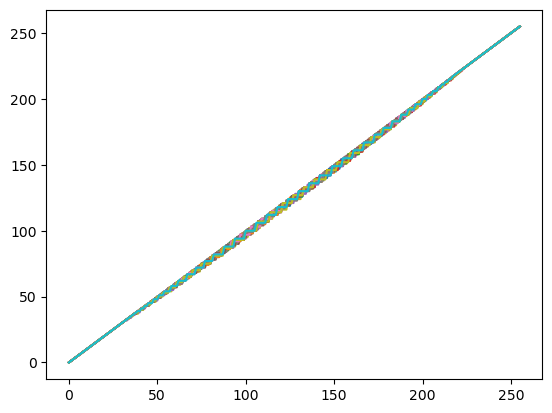

In [62]:
for i,m in enumerate(quantized_matrices):
    min_value, grid_size, cdf, entropy, cross_entropy = create_entropy_model(m, 8)
    ppf = create_ppf(cdf)


    plt.plot([cdf[w] for w in ppf], label=f"{i}")
print(len(cdf))
print(len(ppf))

## Entropy Coder

In [63]:
class AnsCoder:
    def __init__(self, precision, word_size, compressed=[]):
        self.precision = precision
        self.word_size = word_size
        self.word_mask = (1 << word_size) - 1
        self.quantile_mask = (1 << precision) - 1
        self.bulk = compressed.copy()
        self.head = 0
        while len(self.bulk) != 0 and (self.head >> word_size) == 0:
            self.head = (self.head << word_size) | self.bulk.pop()

    def push(self, symbol, cdf):
        prob = (cdf[symbol + 1] - cdf[symbol]).item()
        if (self.head >> (2 * self.word_size - self.precision)) >= prob:
            self.bulk.append(self.head & self.word_mask)
            self.head >>= self.word_size

        # print(f'pushing {symbol} with prob {prob} and cdf {cdf[symbol]} onto {self.head}')
        z = self.head % prob + cdf[symbol].item()
        self.head = ((self.head // prob) << self.precision) | z

    def pop(self, cdf, ppf):
        z = self.head & self.quantile_mask
        self.head >>= self.precision
        # symbol = cdf.searchsorted(z, side='right').item() - 1
        symbol = ppf[z]
        # here weird stuff is happening since cdf can contain 256
        prob = ((cdf[symbol + 1] - cdf[symbol]).item()) & 0xFF 
        self.head = self.head * prob + (z - cdf[symbol].item())
        if (self.head >> self.word_size) == 0 and len(self.bulk) != 0:
            self.head = (self.head << self.word_size) | self.bulk.pop()
        return symbol

    def get_compressed(self):
        compressed = self.bulk.copy()
        head = self.head
        while head != 0:
            compressed.append(head & self.word_mask)
            head >>= self.word_size
        return compressed
    
    def interrupt(self):
        while self.head != 0:
            self.bulk.append(self.head & self.word_mask)
            self.head >>= self.word_size
        self.head = 1 << self.word_size
        return len(self.bulk)

## Compress the Matrices

In [64]:
class CompressedMatrix:
    def __init__(self, rows, cols, grid_spacing, cursors, min_value, cdf,ppf, payload):
        self.rows = rows
        self.cols = cols
        self.grid_spacing = grid_spacing
        self.cursors = cursors
        self.min_value = min_value
        self.cdf = (cdf & 0xFF).astype(np.uint8) # only take lowest 8 bit
        self.ppf= (ppf & 0xFF).astype(np.uint8)

        self.payload = payload # unpadded; will be padded to an even length upon serialization.
    
    def compressed_word_count(self):
        evend_payload_size = len(self.payload) + len(self.payload) % 2
        return (4 + self.rows) * 2 + (3 + len(self.cdf)) // 2 + evend_payload_size

    def serialize(self, file):
        payload_size = len(self.payload) 
        file.write(struct.pack(
            f'<LLf{self.rows}LLbB{len(self.cdf)}B',
            self.rows,
            self.cols,
            self.grid_spacing,
            *self.cursors,
            payload_size,
            self.min_value,
            len(self.cdf) - 1, # ignored grid_size here 
            *(self.cdf),
        ))

        if len(self.cdf) % 2 == 1:
            file.write(b'\0')
        
        # writing ppf 
        file.write(struct.pack(
            f'<256B',*(self.ppf)
        ))

        if sys.byteorder == 'little':
            self.payload.tofile(file)
        else:
            self.payload.byteswap().tofile(file)

        if len(self.payload) % 2 == 1:
            file.write(b'\0\0')
    
    @staticmethod
    def deserialize(file):
        """ Reads binary data from a file and reconstructs a CompressedMatrix object """
        # read number of rows and columns and grid_spacing
        rows, cols, grid_spacing = struct.unpack("<LLf", file.read(12))

        # get cursors using number of rows
        cursors = np.fromfile(file, dtype=np.uint32, count=rows) #check
        
        # get payload size
        payload_size, min_value, G = struct.unpack("<LbB",file.read(6))
        
        # Read the CDF values
        cdf_len = G + 1
        cdf_data = np.fromfile(file, dtype=np.uint8, count=cdf_len)
        if cdf_len % 2 == 1:
            file.seek(1,1)

        ppf = np.fromfile(file, dtype=np.uint8, count=256)
        # read payload
        payload = np.fromfile(file, dtype=np.uint16, count=payload_size)

        # skip 2 bytes if payload is an uneven number of 
        if payload_size % 2 ==1:
            file.seek(2,1)           

        # If system is big-endian, swap bytes
        if sys.byteorder != 'little':
            payload = payload.byteswap()

        return CompressedMatrix(rows, cols, grid_spacing, cursors, min_value, cdf_data,ppf, payload)

In [ ]:
def encode_matrix(matrix, precision = 8):
    min_value, _grid_size, cdf, _entropy, _cross_entropy = create_entropy_model(matrix, precision)
    print(f"Entropy of matrix: {_entropy} bits" )
    print(f"Entropy of matrix: {_cross_entropy} bits" )
    ppf = create_ppf(cdf)
    # print(len(cdf))
    coder = AnsCoder(precision, 16, [0,1])
    back_cursors = np.empty(matrix.shape[0], dtype=np.uint32)

    for row in range(matrix.shape[0] - 1, -1, -1): # iterates in reverse order 
        for entry in matrix[row, ::-1]: # iterates in reverse order due to stack semantics of ANS
            coder.push(entry.item() - min_value, cdf)
        back_cursors[row] = coder.interrupt()
    
    payload = np.array(coder.bulk[::-1], dtype=np.uint16)
    cursors = len(payload) - back_cursors
    return CompressedMatrix(matrix.shape[0], matrix.shape[1], 1.0, cursors, min_value, cdf,ppf, payload) # 1 here is for debugging purposes?

encoded_matrices = [encode_matrix(matrix) for matrix in tqdm(quantized_matrices)]

  0%|          | 0/20 [00:00<?, ?it/s]

Entropy of matrix: 5.857737402753594 bits
Entropy of matrix: 6.168375595620091 bits


  5%|▌         | 1/20 [00:01<00:19,  1.02s/it]

Entropy of matrix: 5.797453090447471 bits
Entropy of matrix: 6.102338745545694 bits


 10%|█         | 2/20 [00:02<00:18,  1.01s/it]

Entropy of matrix: 5.856472835353916 bits
Entropy of matrix: 6.154199073336713 bits


 15%|█▌        | 3/20 [00:02<00:16,  1.01it/s]

Entropy of matrix: 5.902377479161336 bits
Entropy of matrix: 6.20773801940004 bits


 20%|██        | 4/20 [00:03<00:15,  1.03it/s]

Entropy of matrix: 5.826210413731916 bits
Entropy of matrix: 6.116016769110047 bits


 25%|██▌       | 5/20 [00:04<00:14,  1.02it/s]

Entropy of matrix: 5.710389748640571 bits
Entropy of matrix: 5.979552208443238 bits


 30%|███       | 6/20 [00:05<00:13,  1.03it/s]

Entropy of matrix: 5.933121601331964 bits
Entropy of matrix: 6.220370498960165 bits


 35%|███▌      | 7/20 [00:06<00:12,  1.03it/s]

Entropy of matrix: 5.778173981744176 bits
Entropy of matrix: 6.053513536116952 bits


 40%|████      | 8/20 [00:07<00:11,  1.04it/s]

Entropy of matrix: 5.630869600994755 bits
Entropy of matrix: 5.874368495884482 bits


 45%|████▌     | 9/20 [00:08<00:10,  1.04it/s]

Entropy of matrix: 5.776001969197516 bits
Entropy of matrix: 6.07165598831898 bits


 50%|█████     | 10/20 [00:09<00:10,  1.01s/it]

Entropy of matrix: 5.745434686428656 bits
Entropy of matrix: 6.01886422684629 bits


 55%|█████▌    | 11/20 [00:10<00:09,  1.01s/it]

Entropy of matrix: 5.738612715569603 bits
Entropy of matrix: 6.008769138482421 bits


 60%|██████    | 12/20 [00:11<00:07,  1.00it/s]

Entropy of matrix: 5.656624041957221 bits
Entropy of matrix: 5.936844440916957 bits


 65%|██████▌   | 13/20 [00:12<00:07,  1.01s/it]

Entropy of matrix: 5.6738890878412125 bits
Entropy of matrix: 5.937226505836406 bits


 70%|███████   | 14/20 [00:13<00:05,  1.02it/s]

Entropy of matrix: 5.688752523752042 bits
Entropy of matrix: 5.941198303688452 bits


 75%|███████▌  | 15/20 [00:14<00:04,  1.03it/s]

Entropy of matrix: 5.789290692401902 bits
Entropy of matrix: 6.0747086135475 bits


 80%|████████  | 16/20 [00:15<00:03,  1.02it/s]

Entropy of matrix: 5.879199022798872 bits
Entropy of matrix: 6.175946213952102 bits


 85%|████████▌ | 17/20 [00:16<00:03,  1.01s/it]

Entropy of matrix: 5.781876145197163 bits
Entropy of matrix: 6.06147932776048 bits


 90%|█████████ | 18/20 [00:17<00:02,  1.01s/it]

Entropy of matrix: 5.702771629686577 bits
Entropy of matrix: 5.981360362232408 bits


 95%|█████████▌| 19/20 [00:18<00:01,  1.00s/it]

Entropy of matrix: 5.783860898822406 bits
Entropy of matrix: 6.079900405195076 bits


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


## Serialize to a file

In [86]:
def serialize_file_header(file, num_matrices, max_word_count):
    print(f"Num_matrices: {num_matrices}, Max_word_count: {max_word_count}")
    file.write(struct.pack('<LL', num_matrices, max_word_count))

def serialize_vector(file, vec):
    print(f"len_v: {len(vec)}")
    file.write(struct.pack('<L', len(vec)))
    # whatever you system does, we like little endian
    if sys.byteorder == 'little': 
        vec.astype(np.int8).tofile(file)
    else:
        vec.astype(np.int8).byteswap().tofile(file)

    file.write(b'\0' * (3 - (len(vec) + 3) % 4))

In [87]:
max_word_count = max(m.compressed_word_count() for m in encoded_matrices)


with open('compressed_matrices.bin', 'wb') as file:
    serialize_file_header(file, len(quantized_matrices), max_word_count)
    serialize_vector(file, vector)
    for matrix in encoded_matrices:
        matrix.serialize(file)

!ls -l compressed_matrices.bin
!ls -lh compressed_matrices.bin

Num_matrices: 20, Max_word_count: 103831
len_v: 512
-rw-r--r-- 1 wildug wildug 4052804 21. Sep 21:48 compressed_matrices.bin
-rw-r--r-- 1 wildug wildug 3,9M 21. Sep 21:48 compressed_matrices.bin


## Read from a file:

In [88]:
def decode_mat(quant_mat, precision = 8, k = 0):
    # TODO remove k
    for r in range(0,quant_mat.rows):
        cursor = quant_mat.cursors[r]
        if r == quant_mat.rows -1:
            cursorp1 = None
        else:
            cursorp1 = quant_mat.cursors[r+1]
        # print(cursor, cursorp1, len(quant_mat.payload))
        coder = AnsCoder(precision, 16, list(quant_mat.payload[cursor:cursorp1])[::-1]) # the ::-1 is VERY important
        for c in range(quant_mat.rows):
            # print("Head: ",coder.head)
            # print("Bulk: ",coder.bulk[-5:][::-1])
            w = coder.pop(quant_mat.cdf,quant_mat.ppf)+quant_mat.min_value
            # print("Dec:",w, " col:", c)
            assert w == quantized_matrices[k,r,c]

In [89]:
with open('compressed_matrices.bin', 'rb') as file:
    # read first 12 bytes for num_matrices, max_word_count and length of vector

    num_matrices, max_word_count, len_v  = struct.unpack("<LLL", file.read(12)) # check
    print("num_matrices: ",num_matrices)
    print("max_word_count: ",max_word_count)
    print("len_v: ",len_v)
    v = np.fromfile(file, dtype=np.int8, count=len_v) # check
    print("v[1]: ", v[1])

    pad_size = (3 - (len_v + 3) % 4)
    pad = struct.unpack(f"{pad_size}b",file.read(pad_size)) # check

    for k in range(num_matrices):
        quant_mat = CompressedMatrix.deserialize(file)
        print(len(quant_mat.cdf))
        for i,p in enumerate(list(quant_mat.cdf)):
            print(f"cdf[{i}]={p}")
        decode_mat(quant_mat,k = k)
        for attr1, attr2 in zip(vars(quant_mat), vars(encoded_matrices[k])):
            if attr1 != attr2:
                print(f"Mismatch: {attr1} != {attr2}")
            assert attr1 == attr2
        
        


num_matrices:  20
max_word_count:  103831
len_v:  512
v[1]:  -6
252
cdf[0]=0
cdf[1]=1
cdf[2]=1
cdf[3]=2
cdf[4]=2
cdf[5]=3
cdf[6]=3
cdf[7]=4
cdf[8]=4
cdf[9]=4
cdf[10]=4
cdf[11]=5
cdf[12]=5
cdf[13]=6
cdf[14]=6
cdf[15]=7
cdf[16]=7
cdf[17]=8
cdf[18]=8
cdf[19]=9
cdf[20]=9
cdf[21]=10
cdf[22]=10
cdf[23]=11
cdf[24]=11
cdf[25]=12
cdf[26]=12
cdf[27]=13
cdf[28]=13
cdf[29]=14
cdf[30]=14
cdf[31]=15
cdf[32]=15
cdf[33]=16
cdf[34]=16
cdf[35]=17
cdf[36]=17
cdf[37]=18
cdf[38]=18
cdf[39]=19
cdf[40]=19
cdf[41]=20
cdf[42]=20
cdf[43]=21
cdf[44]=21
cdf[45]=22
cdf[46]=22
cdf[47]=23
cdf[48]=23
cdf[49]=24
cdf[50]=24
cdf[51]=25
cdf[52]=25
cdf[53]=26
cdf[54]=26
cdf[55]=27
cdf[56]=27
cdf[57]=28
cdf[58]=28
cdf[59]=29
cdf[60]=29
cdf[61]=30
cdf[62]=30
cdf[63]=31
cdf[64]=31
cdf[65]=31
cdf[66]=32
cdf[67]=32
cdf[68]=33
cdf[69]=33
cdf[70]=34
cdf[71]=34
cdf[72]=35
cdf[73]=35
cdf[74]=36
cdf[75]=36
cdf[76]=37
cdf[77]=37
cdf[78]=38
cdf[79]=38
cdf[80]=39
cdf[81]=39
cdf[82]=40
cdf[83]=40
cdf[84]=41
cdf[85]=41
cdf[86]=42
cdf[87

/tmp/ipykernel_4836/2890179556.py:28: RuntimeWarning: overflow encountered in scalar subtract
  prob = ((cdf[symbol + 1] - cdf[symbol]).item()) & 0xFF


252
cdf[0]=0
cdf[1]=1
cdf[2]=1
cdf[3]=2
cdf[4]=2
cdf[5]=2
cdf[6]=2
cdf[7]=2
cdf[8]=2
cdf[9]=2
cdf[10]=2
cdf[11]=3
cdf[12]=3
cdf[13]=4
cdf[14]=4
cdf[15]=5
cdf[16]=5
cdf[17]=6
cdf[18]=6
cdf[19]=7
cdf[20]=7
cdf[21]=8
cdf[22]=8
cdf[23]=9
cdf[24]=9
cdf[25]=10
cdf[26]=10
cdf[27]=11
cdf[28]=11
cdf[29]=12
cdf[30]=12
cdf[31]=13
cdf[32]=13
cdf[33]=14
cdf[34]=14
cdf[35]=15
cdf[36]=15
cdf[37]=16
cdf[38]=16
cdf[39]=17
cdf[40]=17
cdf[41]=18
cdf[42]=18
cdf[43]=19
cdf[44]=19
cdf[45]=20
cdf[46]=20
cdf[47]=21
cdf[48]=21
cdf[49]=22
cdf[50]=22
cdf[51]=23
cdf[52]=23
cdf[53]=24
cdf[54]=24
cdf[55]=25
cdf[56]=25
cdf[57]=26
cdf[58]=26
cdf[59]=27
cdf[60]=27
cdf[61]=28
cdf[62]=28
cdf[63]=29
cdf[64]=29
cdf[65]=29
cdf[66]=30
cdf[67]=30
cdf[68]=31
cdf[69]=31
cdf[70]=32
cdf[71]=32
cdf[72]=33
cdf[73]=33
cdf[74]=34
cdf[75]=34
cdf[76]=35
cdf[77]=35
cdf[78]=36
cdf[79]=36
cdf[80]=37
cdf[81]=37
cdf[82]=38
cdf[83]=38
cdf[84]=39
cdf[85]=39
cdf[86]=40
cdf[87]=40
cdf[88]=42
cdf[89]=42
cdf[90]=44
cdf[91]=44
cdf[92]=46
cdf[93]=

In [90]:
quantized_matrices[0,0,:10]

vals = [-19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
cdf = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 27, 38, 52, 70, 92, 116, 140, 164, 185, 203, 218, 229, 236, 241, 245, 247, 248, 249, 250, 251, 252, 253, 254, 255, 0]
len(vals), len(cdf)

(39, 39)

## Debugging

In [91]:
# Checksum adapted from rust's FxHash, but restricted to 26 bit hashes so that the
# multiplication doesn't exceed the range of exactly representable integers in JavaScript.
def get_checksum(data):
    checksum = 0
    for value in data.ravel():
        # Convert `value` into a unique positive value to avoid architecture- and
        # precision-dependent behavior in the bit manipulations below.
        value = value.item()
        if value < 0:
            # Negative `value`s are mapped to odd positive numbers ...
            value = -2 * value + 1
        else:
            # ... and positive `value`s are mapped to even positive numbers.
            value = 2 * value

        checksum = ((checksum & 0x001f_ffff) << 5) | (checksum >> 21) # rotate
        checksum = (checksum ^ value) * 0x0322_0a95
        checksum = checksum & 0x03ff_ffff # truncate to 26 bit
    return checksum

In [92]:
print(f'checksum of vector: {get_checksum(vector)}')

for i, quantized_matrix in enumerate(quantized_matrices):
    print(f'checksum of matrix {i}: {get_checksum(quantized_matrix)}')

checksum of vector: 21885043
checksum of matrix 0: 9235975
checksum of matrix 1: 23039573
checksum of matrix 2: 65072887
checksum of matrix 3: 52445753
checksum of matrix 4: 31063923
checksum of matrix 5: 43199760
checksum of matrix 6: 26416057
checksum of matrix 7: 31777603
checksum of matrix 8: 19781510
checksum of matrix 9: 43258448
checksum of matrix 10: 41805597
checksum of matrix 11: 37306887
checksum of matrix 12: 12656334
checksum of matrix 13: 38198100
checksum of matrix 14: 867869
checksum of matrix 15: 20061323
checksum of matrix 16: 21177385
checksum of matrix 17: 54804940
checksum of matrix 18: 12350443
checksum of matrix 19: 24853410
